c:\Users\Desktop\AppData\Local\Programs\Python\Python314\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda
Aligned APs: 12
Initializing ST-AGNN (LSTM + AGNN)...
Start Training...
Epoch 10 | Train: 0.2822 | Val: 0.3726
Epoch 20 | Train: 0.2516 | Val: 0.3168
Epoch 30 | Train: 0.2404 | Val: 0.3045
Epoch 40 | Train: 0.2448 | Val: 0.3065
Epoch 50 | Train: 0.2383 | Val: 0.3038
Epoch 60 | Train: 0.2460 | Val: 0.3037
Epoch 70 | Train: 0.2441 | Val: 0.3042
Epoch 80 | Train: 0.2402 | Val: 0.3041
Epoch 90 | Train: 0.2425 | Val: 0.3041
Epoch 100 | Train: 0.2483 | Val: 0.3041
Epoch 110 | Train: 0.2457 | Val: 0.3041
Epoch 120 | Train: 0.2392 | Val: 0.3041
Epoch 130 | Train: 0.2399 | Val: 0.3041
Epoch 140 | Train: 0.2472 | Val: 0.3041
Epoch 150 | Train: 0.2412 | Val: 0.3041
Testing & Smoothing...
ST-AGNN Results:
  Raw RMSE: 5.3703m
  Smoothed RMSE: 5.2104m
Plot saved.


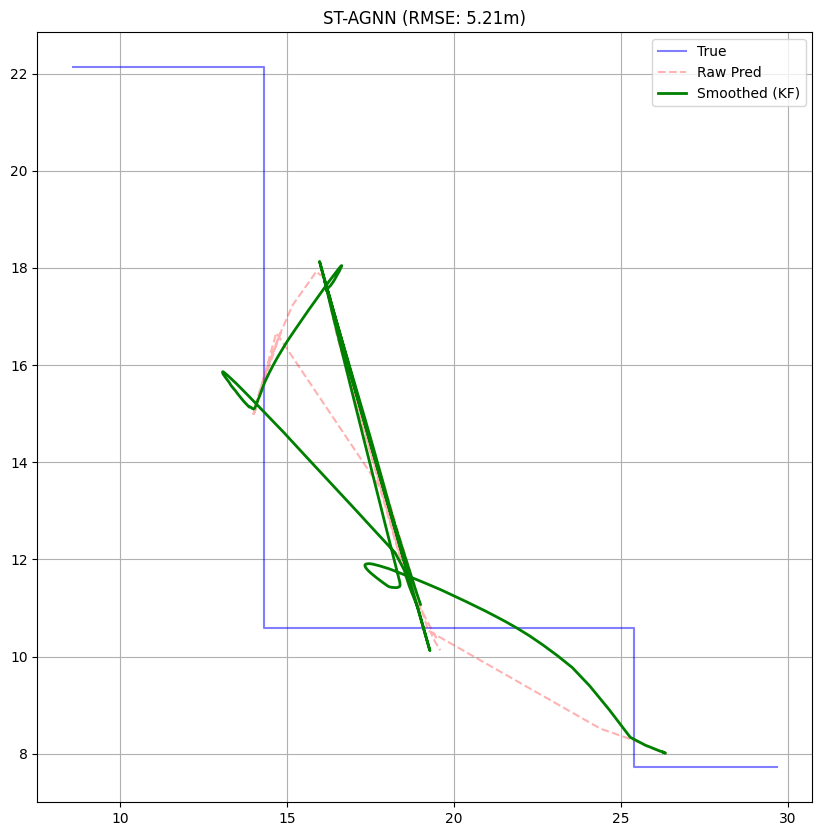

In [1]:
# -*- coding: utf-8 -*-
"""
ST-AGNN: 时空图注意力网络 (Spatio-Temporal AGNN)
------------------------------------------------
完美结合时序与空间特征：
1. Temporal: 使用 Shared LSTM 独立提取每个 AP 的时序特征 (趋势感知)。
2. Spatial: 使用 AGNN 根据特征相似度聚合 AP 信息 (抗噪)。
3. Pooling: Attention Pooling (自动加权)。
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import os
import matplotlib.pyplot as plt

try:
    from torch_geometric.nn import AGNNConv
except ImportError:
    print("错误: 需要安装 torch_geometric")
    exit()

# 设置随机种子
torch.manual_seed(42)
np.random.seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# ==============================================================================
#                 第一部分: 配置与数据加载
# ==============================================================================

CONFIG = {
    'data_dir': 'Datasets/Zoulang/',
    'train_file': 'train.csv',
    'val_file': 'validation.csv',
    'test_file': 'test.csv',
    'window_size': 20,      # 20帧 (约1秒) 是最佳平衡点
    'batch_size': 64,
    'lr': 0.001,
    'epochs': 150,
    'hidden_dim': 64        # 适中的维度
}

class RSSIDataset(Dataset):
    def __init__(self, df, wifi_cols, coord_cols, window_size, scaler=None, coord_scaler=None):
        self.window_size = window_size
        self.df = df.reset_index(drop=True)
        
        wifi_data = self.df[wifi_cols].values.astype(np.float32)
        coords = self.df[coord_cols].values.astype(np.float32)
        
        # 物理归一化
        wifi_data[wifi_data > 0] = -100.0
        wifi_data = np.clip(wifi_data, -100.0, 0.0)
        self.wifi_data = (wifi_data + 100.0) / 100.0
        
        self.coords = coords
        if coord_scaler is None:
            self.coord_scaler = StandardScaler()
            self.coords = self.coord_scaler.fit_transform(self.coords)
        else:
            self.coord_scaler = coord_scaler
            self.coords = self.coord_scaler.transform(self.coords)

    def __len__(self):
        return len(self.df) - self.window_size

    def __getitem__(self, idx):
        x = self.wifi_data[idx : idx + self.window_size]
        y = self.coords[idx + self.window_size - 1]
        return torch.tensor(x), torch.tensor(y)

def get_data_loaders():
    paths = [os.path.join(CONFIG['data_dir'], f) for f in [CONFIG['train_file'], CONFIG['val_file'], CONFIG['test_file']]]
    if not all(os.path.exists(p) for p in paths):
        print("Error: Data files missing.")
        return None

    train_df = pd.read_csv(paths[0])
    val_df = pd.read_csv(paths[1])
    test_df = pd.read_csv(paths[2])

    def get_cols(df): return set([c for c in df.columns if "RSSI" in c or "distance" in c])
    common_wifi = list(get_cols(train_df).intersection(get_cols(val_df)).intersection(get_cols(test_df)))
    common_wifi.sort()
    coord_cols = ['x_coord', 'y_coord']
    
    print(f"Aligned APs: {len(common_wifi)}")

    # EMA 平滑 (基础去噪)
    for df in [train_df, val_df, test_df]:
        df[common_wifi] = df[common_wifi].ewm(span=3).mean()

    train_set = RSSIDataset(train_df, common_wifi, coord_cols, CONFIG['window_size'], None, None)
    val_set = RSSIDataset(val_df, common_wifi, coord_cols, CONFIG['window_size'], None, train_set.coord_scaler)
    test_set = RSSIDataset(test_df, common_wifi, coord_cols, CONFIG['window_size'], None, train_set.coord_scaler)

    return (
        DataLoader(train_set, batch_size=CONFIG['batch_size'], shuffle=True, drop_last=True),
        DataLoader(val_set, batch_size=CONFIG['batch_size'], shuffle=False),
        DataLoader(test_set, batch_size=1, shuffle=False),
        len(common_wifi),
        train_set.coord_scaler
    )

# ==============================================================================
#                 第二部分: ST-AGNN 模型 (核心)
# ==============================================================================

class SharedLSTMEncoder(nn.Module):
    """
    共享权重的 LSTM 编码器。
    它把每个 AP 看作独立的序列，提取出每个 AP 的 '状态特征'。
    """
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        
    def forward(self, x):
        # x: [Batch * Nodes, Window, 1]
        # 我们只关心最后时刻的 hidden state
        _, (h_n, _) = self.lstm(x) 
        return h_n[-1] # [Batch * Nodes, Hidden]

class ST_AGNN(nn.Module):
    def __init__(self, num_nodes, window_size, hidden_dim=64):
        super(ST_AGNN, self).__init__()
        self.num_nodes = num_nodes
        
        # 1. Temporal Encoding (Shared LSTM)
        # 输入维度是 1 (因为我们把每个AP单独看)，输出 Hidden
        self.node_encoder = SharedLSTMEncoder(input_dim=1, hidden_dim=hidden_dim)
        
        # 2. Spatial GNN (AGNN)
        self.agnn1 = AGNNConv(requires_grad=True)
        self.agnn2 = AGNNConv(requires_grad=True)
        self.norm1 = nn.LayerNorm(hidden_dim)
        
        # 3. Attention Pooling (替代简单的 Mean Pooling)
        # 自动学习哪些 AP 是重要的
        self.attn_pool = nn.Sequential(
            nn.Linear(hidden_dim, 1),
            nn.Tanh(),
            nn.Softmax(dim=1) # 对 Nodes 维度归一化
        )
        
        # 4. Regressor
        self.regressor = nn.Sequential(
            nn.Linear(hidden_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 2)
        )
        
        self.register_buffer('static_edge_index', self._build_fc_graph(num_nodes))

    def _build_fc_graph(self, num_nodes):
        src = torch.arange(num_nodes).repeat_interleave(num_nodes)
        dst = torch.arange(num_nodes).repeat(num_nodes)
        return torch.stack([src, dst], dim=0)

    def forward(self, x):
        # x: [Batch, Window, Nodes]
        B, W, N = x.shape
        
        # --- 1. Temporal Feature Extraction ---
        # 变换为: [Batch * Nodes, Window, 1]
        # 这一步是关键！我们把所有AP的时间序列“拆开”分别送入LSTM
        x_input = x.permute(0, 2, 1).reshape(B * N, W, 1)
        
        # h_nodes: [Batch * Nodes, Hidden]
        h_nodes = self.node_encoder(x_input)
        
        # --- 2. Spatial Propagation ---
        num_edges = self.static_edge_index.size(1)
        edge_index = self.static_edge_index.repeat(1, B)
        offset = torch.arange(B, device=x.device).repeat_interleave(num_edges) * N
        edge_index = edge_index + offset
        
        # AGNN Prop
        h_gnn = self.agnn1(h_nodes, edge_index)
        h_gnn = F.relu(h_gnn)
        h_gnn = self.agnn2(h_gnn, edge_index)
        
        # Residual + Norm
        h = self.norm1(h_nodes + h_gnn)
        
        # --- 3. Attention Pooling ---
        # 还原维度: [Batch, Nodes, Hidden]
        h_view = h.view(B, N, -1)
        
        # 计算注意力权重: [Batch, Nodes, 1]
        attn_weights = self.attn_pool(h_view)
        
        # 加权求和: [Batch, Hidden]
        graph_feat = torch.sum(h_view * attn_weights, dim=1)
        
        # --- 4. Prediction ---
        out = self.regressor(graph_feat)
        return out

# ==============================================================================
#                 第三部分: 训练与评估
# ==============================================================================

class KalmanFilter2D:
    def __init__(self, process_noise=1e-4, measurement_noise=1.0):
        self.F = np.array([[1, 0, 1, 0], [0, 1, 0, 1], [0, 0, 1, 0], [0, 0, 0, 1]], dtype=np.float32)
        self.H = np.array([[1, 0, 0, 0], [0, 1, 0, 0]], dtype=np.float32)
        self.Q = np.eye(4, dtype=np.float32) * process_noise
        self.R = np.eye(2, dtype=np.float32) * measurement_noise
        self.P = np.eye(4, dtype=np.float32)
        self.x = np.zeros((4, 1), dtype=np.float32)

    def initialize(self, x, y):
        self.x = np.array([[x], [y], [0], [0]], dtype=np.float32)

    def update(self, zx, zy):
        self.x = self.F @ self.x
        self.P = self.F @ self.P @ self.F.T + self.Q
        z = np.array([[zx], [zy]], dtype=np.float32)
        y = z - self.H @ self.x
        S = self.H @ self.P @ self.H.T + self.R
        K = self.P @ self.H.T @ np.linalg.inv(S)
        self.x = self.x + K @ y
        self.P = (np.eye(4) - K @ self.H) @ self.P
        return self.x[0, 0], self.x[1, 0]

def main():
    # 1. Data
    data = get_data_loaders()
    if data is None: return
    train_l, val_l, test_l, num_aps, scaler = data
    
    # 2. Model
    print("Initializing ST-AGNN (LSTM + AGNN)...")
    model = ST_AGNN(num_nodes=num_aps, window_size=CONFIG['window_size'], hidden_dim=CONFIG['hidden_dim']).to(device)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=CONFIG['lr'], weight_decay=1e-4)
    criterion = nn.SmoothL1Loss(beta=1.0)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10)
    
    # 3. Train
    best_loss = float('inf')
    print("Start Training...")
    
    for epoch in range(CONFIG['epochs']):
        model.train()
        train_loss = 0
        for x, y in train_l:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            pred = model(x)
            loss = criterion(pred, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for x, y in val_l:
                x, y = x.to(device), y.to(device)
                pred = model(x)
                val_loss += criterion(pred, y).item()
        
        avg_val = val_loss / len(val_l)
        scheduler.step(avg_val)
        
        if avg_val < best_loss:
            best_loss = avg_val
            torch.save(model.state_dict(), 'best_st_agnn.pth')
            
        if (epoch+1)%10 == 0:
            print(f"Epoch {epoch+1} | Train: {train_loss/len(train_l):.4f} | Val: {avg_val:.4f}")

    # 4. Test & Smooth
    print("Testing & Smoothing...")
    model.load_state_dict(torch.load('best_st_agnn.pth'))
    model.eval()
    
    kf = KalmanFilter2D(process_noise=1e-5, measurement_noise=1.5)
    
    preds_raw, preds_smooth, targets = [], [], []
    first = True
    
    with torch.no_grad():
        for x, y in test_l:
            x = x.to(device)
            pred = model(x).cpu().numpy()
            y = y.cpu().numpy()
            
            pred_real = scaler.inverse_transform(pred)[0]
            y_real = scaler.inverse_transform(y)[0]
            
            preds_raw.append(pred_real)
            targets.append(y_real)
            
            if first:
                kf.initialize(pred_real[0], pred_real[1])
                preds_smooth.append(pred_real)
                first = False
            else:
                sx, sy = kf.update(pred_real[0], pred_real[1])
                preds_smooth.append([sx, sy])
            
    preds_raw = np.array(preds_raw)
    preds_smooth = np.array(preds_smooth)
    targets = np.array(targets)
    
    rmse_raw = np.sqrt(np.mean(np.linalg.norm(preds_raw - targets, axis=1)**2))
    rmse_smooth = np.sqrt(np.mean(np.linalg.norm(preds_smooth - targets, axis=1)**2))
    
    print(f"ST-AGNN Results:")
    print(f"  Raw RMSE: {rmse_raw:.4f}m")
    print(f"  Smoothed RMSE: {rmse_smooth:.4f}m")
    
    # 保存 CSV
    os.makedirs('results', exist_ok=True)
    pd.DataFrame({
        'True_X': targets[:,0], 'True_Y': targets[:,1],
        'Pred_X': preds_raw[:,0], 'Pred_Y': preds_raw[:,1],
        'Pred_Smooth_X': preds_smooth[:,0], 'Pred_Smooth_Y': preds_smooth[:,1]
    }).to_csv('results/ST_AGNN_Predictions.csv', index=False)

    # Plot
    plt.figure(figsize=(10,10))
    plt.plot(targets[:,0], targets[:,1], 'b-', label='True', alpha=0.5)
    plt.plot(preds_raw[:,0], preds_raw[:,1], 'r--', label='Raw Pred', alpha=0.3)
    plt.plot(preds_smooth[:,0], preds_smooth[:,1], 'g-', linewidth=2, label='Smoothed (KF)')
    plt.title(f"ST-AGNN (RMSE: {rmse_smooth:.2f}m)")
    plt.legend()
    plt.grid()
    os.makedirs('Picture', exist_ok=True)
    plt.savefig('Picture/ST_AGNN_Result.png')
    print("Plot saved.")

if __name__ == '__main__':
    main()

In [ ]:
# -*- coding: utf-8 -*-
"""
ST-AGNN (Single Dataset): 时空图注意力网络
------------------------------------------
修改说明:
1. 数据加载: 改为读取单个 CSV 文件，按 8:1:1 顺序自动切分。
2. 保持了 ST-AGNN 的所有核心特性 (Shared LSTM + AGNN + Attention Pooling)。
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import os
import matplotlib.pyplot as plt

try:
    from torch_geometric.nn import AGNNConv
except ImportError:
    print("错误: 需要安装 torch_geometric")
    exit()

# 设置随机种子
torch.manual_seed(42)
np.random.seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# ==============================================================================
#                 第一部分: 配置与数据加载 (单文件切分版)
# ==============================================================================

CONFIG = {
    'data_dir': 'Datasets/',
    'filename': '0.275_Speed_OB.csv', # [修改] 指定单个文件名
    
    'window_size': 20,      # 20帧 (约1秒) 是最佳平衡点
    'batch_size': 64,
    'lr': 0.001,
    'epochs': 150,
    'hidden_dim': 64        
}

class RSSIDataset(Dataset):
    def __init__(self, df, wifi_cols, coord_cols, window_size, scaler=None, coord_scaler=None):
        self.window_size = window_size
        self.df = df.reset_index(drop=True)
        
        wifi_data = self.df[wifi_cols].values.astype(np.float32)
        coords = self.df[coord_cols].values.astype(np.float32)
        
        # 物理归一化
        wifi_data[wifi_data > 0] = -100.0
        wifi_data = np.clip(wifi_data, -100.0, 0.0)
        self.wifi_data = (wifi_data + 100.0) / 100.0
        
        self.coords = coords
        if coord_scaler is None:
            self.coord_scaler = StandardScaler()
            self.coords = self.coord_scaler.fit_transform(self.coords)
        else:
            self.coord_scaler = coord_scaler
            self.coords = self.coord_scaler.transform(self.coords)

    def __len__(self):
        return len(self.df) - self.window_size

    def __getitem__(self, idx):
        x = self.wifi_data[idx : idx + self.window_size]
        y = self.coords[idx + self.window_size - 1]
        return torch.tensor(x), torch.tensor(y)

def get_data_loaders():
    # [修改] 读取单个文件
    file_path = os.path.join(CONFIG['data_dir'], CONFIG['filename'])
    
    if not os.path.exists(file_path):
        print(f"Error: Data file not found at {file_path}")
        return None

    print(f"Loading data from {file_path}...")
    full_df = pd.read_csv(file_path)
    
    # [修改] 按 8:1:1 切分
    n = len(full_df)
    train_end = int(n * 0.8)
    val_end = int(n * 0.9)
    
    print(f"Total samples: {n}")
    print(f"Split: Train(0-{train_end}), Val({train_end}-{val_end}), Test({val_end}-{n})")
    
    # 使用 copy() 防止警告
    train_df = full_df.iloc[:train_end].copy()
    val_df = full_df.iloc[train_end:val_end].copy()
    test_df = full_df.iloc[val_end:].copy()

    # 识别 WiFi 列 (基于训练集)
    wifi_cols = [c for c in train_df.columns if "RSSI" in c or "distance" in c]
    coord_cols = ['x_coord', 'y_coord']
    
    print(f"Features: {len(wifi_cols)} APs")
    
    if len(wifi_cols) == 0:
        print("Error: No WiFi columns found!")
        return None

    # EMA 平滑 (分别对切分后的数据做，防止泄露)
    for df in [train_df, val_df, test_df]:
        df[wifi_cols] = df[wifi_cols].ewm(span=3).mean()

    # 创建 Dataset
    train_set = RSSIDataset(train_df, wifi_cols, coord_cols, CONFIG['window_size'], None, None)
    val_set = RSSIDataset(val_df, wifi_cols, coord_cols, CONFIG['window_size'], None, train_set.coord_scaler)
    test_set = RSSIDataset(test_df, wifi_cols, coord_cols, CONFIG['window_size'], None, train_set.coord_scaler)

    return (
        DataLoader(train_set, batch_size=CONFIG['batch_size'], shuffle=True, drop_last=True),
        DataLoader(val_set, batch_size=CONFIG['batch_size'], shuffle=False),
        DataLoader(test_set, batch_size=1, shuffle=False),
        len(wifi_cols),
        train_set.coord_scaler
    )

# ==============================================================================
#                 第二部分: ST-AGNN 模型 (保持不变)
# ==============================================================================

class SharedLSTMEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        
    def forward(self, x):
        _, (h_n, _) = self.lstm(x) 
        return h_n[-1] 

class ST_AGNN(nn.Module):
    def __init__(self, num_nodes, window_size, hidden_dim=64):
        super(ST_AGNN, self).__init__()
        self.num_nodes = num_nodes
        
        self.node_encoder = SharedLSTMEncoder(input_dim=1, hidden_dim=hidden_dim)
        
        self.agnn1 = AGNNConv(requires_grad=True)
        self.agnn2 = AGNNConv(requires_grad=True)
        self.norm1 = nn.LayerNorm(hidden_dim)
        
        self.attn_pool = nn.Sequential(
            nn.Linear(hidden_dim, 1),
            nn.Tanh(),
            nn.Softmax(dim=1) 
        )
        
        self.regressor = nn.Sequential(
            nn.Linear(hidden_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 2)
        )
        
        self.register_buffer('static_edge_index', self._build_fc_graph(num_nodes))

    def _build_fc_graph(self, num_nodes):
        src = torch.arange(num_nodes).repeat_interleave(num_nodes)
        dst = torch.arange(num_nodes).repeat(num_nodes)
        return torch.stack([src, dst], dim=0)

    def forward(self, x):
        B, W, N = x.shape
        
        x_input = x.permute(0, 2, 1).reshape(B * N, W, 1)
        h_nodes = self.node_encoder(x_input)
        
        num_edges = self.static_edge_index.size(1)
        edge_index = self.static_edge_index.repeat(1, B)
        offset = torch.arange(B, device=x.device).repeat_interleave(num_edges) * N
        edge_index = edge_index + offset
        
        h_gnn = self.agnn1(h_nodes, edge_index)
        h_gnn = F.relu(h_gnn)
        h_gnn = self.agnn2(h_gnn, edge_index)
        
        h = self.norm1(h_nodes + h_gnn)
        
        h_view = h.view(B, N, -1)
        attn_weights = self.attn_pool(h_view)
        graph_feat = torch.sum(h_view * attn_weights, dim=1)
        
        out = self.regressor(graph_feat)
        return out

# ==============================================================================
#                 第三部分: 训练与评估
# ==============================================================================

class KalmanFilter2D:
    def __init__(self, process_noise=1e-4, measurement_noise=1.0):
        self.F = np.array([[1, 0, 1, 0], [0, 1, 0, 1], [0, 0, 1, 0], [0, 0, 0, 1]], dtype=np.float32)
        self.H = np.array([[1, 0, 0, 0], [0, 1, 0, 0]], dtype=np.float32)
        self.Q = np.eye(4, dtype=np.float32) * process_noise
        self.R = np.eye(2, dtype=np.float32) * measurement_noise
        self.P = np.eye(4, dtype=np.float32)
        self.x = np.zeros((4, 1), dtype=np.float32)

    def initialize(self, x, y):
        self.x = np.array([[x], [y], [0], [0]], dtype=np.float32)

    def update(self, zx, zy):
        self.x = self.F @ self.x
        self.P = self.F @ self.P @ self.F.T + self.Q
        z = np.array([[zx], [zy]], dtype=np.float32)
        y = z - self.H @ self.x
        S = self.H @ self.P @ self.H.T + self.R
        K = self.P @ self.H.T @ np.linalg.inv(S)
        self.x = self.x + K @ y
        self.P = (np.eye(4) - K @ self.H) @ self.P
        return self.x[0, 0], self.x[1, 0]

def main():
    # 1. Data
    data = get_data_loaders()
    if data is None: return
    train_l, val_l, test_l, num_aps, scaler = data
    
    # 2. Model
    print("Initializing ST-AGNN (LSTM + AGNN)...")
    model = ST_AGNN(num_nodes=num_aps, window_size=CONFIG['window_size'], hidden_dim=CONFIG['hidden_dim']).to(device)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=CONFIG['lr'], weight_decay=1e-4)
    criterion = nn.SmoothL1Loss(beta=1.0)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10)
    
    # 3. Train
    best_loss = float('inf')
    print("Start Training...")
    
    for epoch in range(CONFIG['epochs']):
        model.train()
        train_loss = 0
        for x, y in train_l:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            pred = model(x)
            loss = criterion(pred, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for x, y in val_l:
                x, y = x.to(device), y.to(device)
                pred = model(x)
                val_loss += criterion(pred, y).item()
        
        avg_val = val_loss / len(val_l)
        scheduler.step(avg_val)
        
        if avg_val < best_loss:
            best_loss = avg_val
            torch.save(model.state_dict(), 'best_st_agnn.pth')
            
        if (epoch+1)%10 == 0:
            print(f"Epoch {epoch+1} | Train: {train_loss/len(train_l):.4f} | Val: {avg_val:.4f}")

    # 4. Test & Smooth
    print("Testing & Smoothing...")
    model.load_state_dict(torch.load('best_st_agnn.pth'))
    model.eval()
    
    kf = KalmanFilter2D(process_noise=1e-5, measurement_noise=1.5)
    
    preds_raw, preds_smooth, targets = [], [], []
    first = True
    
    with torch.no_grad():
        for x, y in test_l:
            x = x.to(device)
            pred = model(x).cpu().numpy()
            y = y.cpu().numpy()
            
            pred_real = scaler.inverse_transform(pred)[0]
            y_real = scaler.inverse_transform(y)[0]
            
            preds_raw.append(pred_real)
            targets.append(y_real)
            
            if first:
                kf.initialize(pred_real[0], pred_real[1])
                preds_smooth.append(pred_real)
                first = False
            else:
                sx, sy = kf.update(pred_real[0], pred_real[1])
                preds_smooth.append([sx, sy])
            
    preds_raw = np.array(preds_raw)
    preds_smooth = np.array(preds_smooth)
    targets = np.array(targets)
    
    rmse_raw = np.sqrt(np.mean(np.linalg.norm(preds_raw - targets, axis=1)**2))
    rmse_smooth = np.sqrt(np.mean(np.linalg.norm(preds_smooth - targets, axis=1)**2))
    
    print(f"ST-AGNN Results:")
    print(f"  Raw RMSE: {rmse_raw:.4f}m")
    print(f"  Smoothed RMSE: {rmse_smooth:.4f}m")
    
    # 保存 CSV
    os.makedirs('results', exist_ok=True)
    pd.DataFrame({
        'True_X': targets[:,0], 'True_Y': targets[:,1],
        'Pred_X': preds_raw[:,0], 'Pred_Y': preds_raw[:,1],
        'Pred_Smooth_X': preds_smooth[:,0], 'Pred_Smooth_Y': preds_smooth[:,1]
    }).to_csv('results/ST_AGNN_Predictions.csv', index=False)

    # Plot
    plt.figure(figsize=(10,10))
    plt.plot(targets[:,0], targets[:,1], 'b-', label='True', alpha=0.5)
    plt.plot(preds_raw[:,0], preds_raw[:,1], 'r--', label='Raw Pred', alpha=0.3)
    plt.plot(preds_smooth[:,0], preds_smooth[:,1], 'g-', linewidth=2, label='Smoothed (KF)')
    plt.title(f"ST-AGNN (RMSE: {rmse_smooth:.2f}m)")
    plt.legend()
    plt.grid()
    os.makedirs('Picture', exist_ok=True)
    plt.savefig('Picture/ST_AGNN_Result.png')
    print("Plot saved.")

if __name__ == '__main__':
    main()

c:\Users\Desktop\AppData\Local\Programs\Python\Python314\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda
Loading data from Datasets/0.275_Speed_OB.csv...
Total samples: 20302
Split: Train(0-16241), Val(16241-18271), Test(18271-20302)
Features: 4 APs
Initializing ST-AGNN (LSTM + AGNN)...
Start Training...
